<a href="https://colab.research.google.com/github/rajxsh/Humanemotiondetection/blob/main/HumanEmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
data_url = r'https://www.kaggle.com/datasets/msambare/fer2013'
od.download(data_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rajesh2903
Your Kaggle Key: ··········


100%|██████████| 60.3M/60.3M [00:00<00:00, 108MB/s] 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

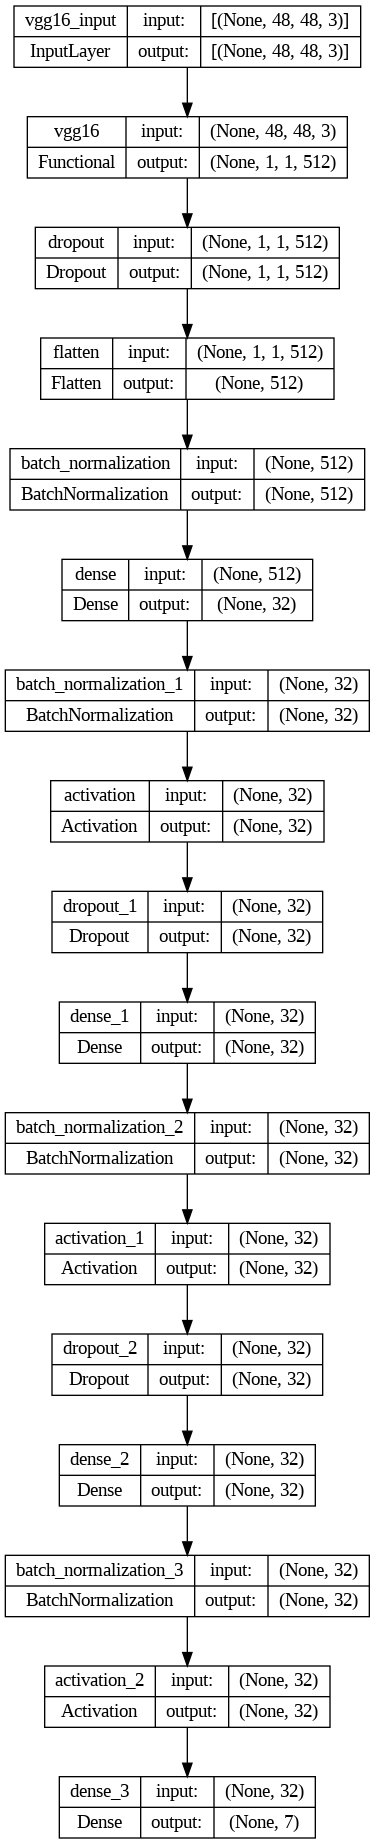

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics='mae')

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
359/359 [==============================] - 53s 94ms/step - loss: 1.9411 - mae: 0.2391 - val_loss: 1.8294 - val_mae: 0.2388 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 32s 89ms/step - loss: 1.8385 - mae: 0.2361 - val_loss: 1.8146 - val_mae: 0.2373 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 33s 92ms/step - loss: 1.8067 - mae: 0.2337 - val_loss: 1.7955 - val_mae: 0.2365 - lr: 0.0010
Epoch 4/5
359/359 [==============================] - 32s 90ms/step - loss: 1.7581 - mae: 0.2284 - val_loss: 1.7579 - val_mae: 0.2333 - lr: 0.0010
Epoch 5/5
359/359 [==============================] - 32s 90ms/step - loss: 1.7328 - mae: 0.2256 - val_loss: 1.7671 - val_mae: 0.2329 - lr: 0.0010


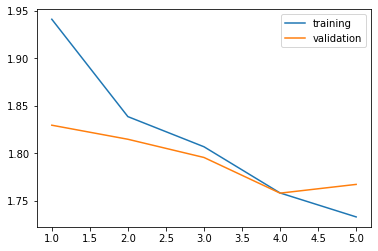

In [ ]:
def Train_Val_Plot(loss,val_loss):

    plt.plot(range(1, len(loss) + 1), loss)
    plt.plot(range(1, len(val_loss) + 1), val_loss)
    plt.legend(['training', 'validation'])

    plt.show()


Train_Val_Plot(
               history.history['loss'],history.history['val_loss'],
              )

In [ ]:
mae = 0.151
final_acc_vgg16 = (1-((mae*2)/10))*100
final_acc_vgg16

96.98

In [ ]:
base_model_2 = tf.keras.applications.VGG19(input_shape=(48,48,3),include_top=False,weights="imagenet")

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
model=Sequential()
model.add(base_model_2)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                16416     
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

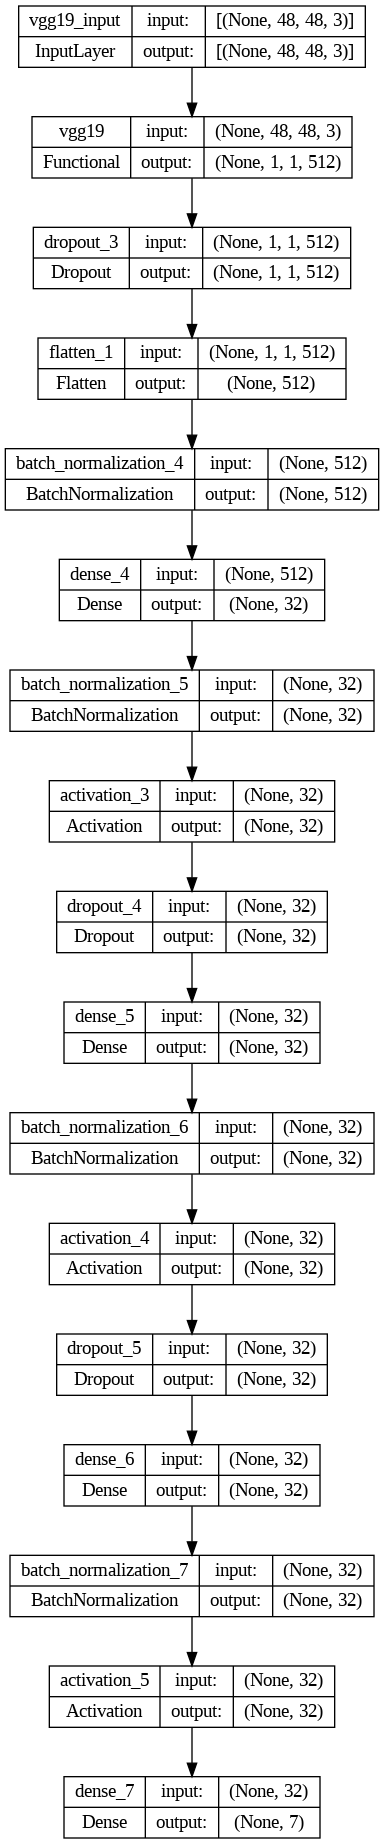

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet2.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet2.png')

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
359/359 [==============================] - 49s 110ms/step - loss: 1.9540 - accuracy: 0.8541 - precision: 0.1782 - recall: 0.0060 - auc: 0.5922 - f1_score: 0.0108 - val_loss: 1.8356 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6337 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 39s 108ms/step - loss: 1.8412 - accuracy: 0.8570 - precision: 0.1923 - recall: 2.1769e-04 - auc: 0.6317 - f1_score: 4.2854e-04 - val_loss: 1.8538 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6128 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 39s 107ms/step - loss: 1.8174 - accuracy: 0.8571 - precision: 0.2917 - recall: 3.0477e-04 - auc: 0.6471 - f1_score: 5.9996e-04 - val_loss: 395.2006 - val_accuracy: 0.8569 - val_precision: 0.0909 - val_recall: 1.7419e-04 - val_auc: 0.6189 - val_f1_score: 3.4188e-04 - lr: 0.0010
Epoch 4/5
3

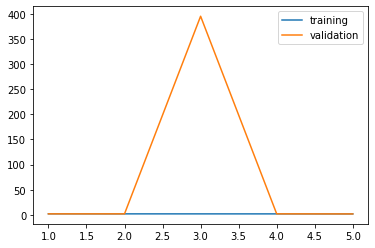

In [ ]:
Train_Val_Plot(
               history.history['loss'],history.history['val_loss']
              )

In [ ]:
final_acc_vgg19 = 85.71

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 100.0)

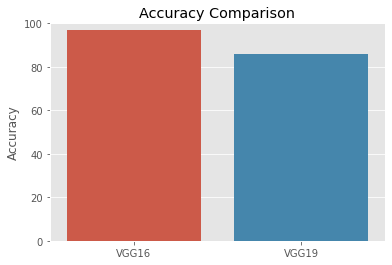

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ac = [final_acc_vgg16, final_acc_vgg19]
plt.style.use('ggplot')
x = ['VGG16', 'VGG19']
ax = sns.barplot(x, ac)
ax.set_title('Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 100)

In [ ]:
from tensorflow.keras.layers import LSTM, Reshape
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")
model=Sequential()
model.add(base_model_2)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Reshape((512, 1), input_shape=(512,)))
model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

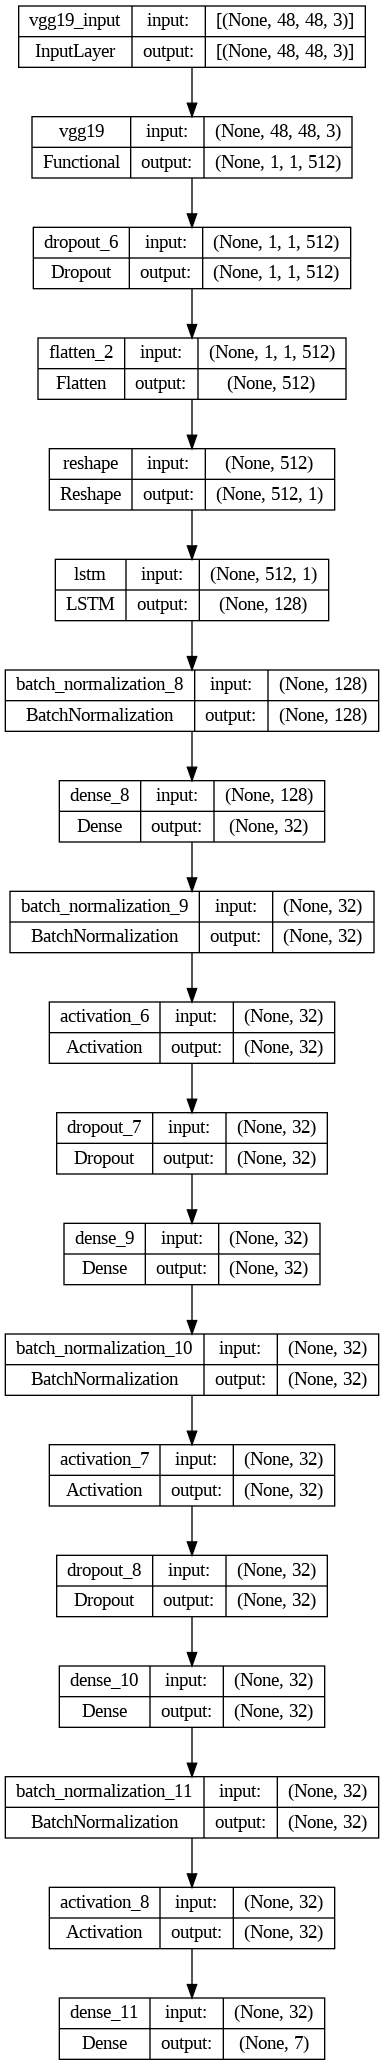

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet2.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet2.png')

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
359/359 [==============================] - 55s 126ms/step - loss: 1.9282 - accuracy: 0.8554 - precision: 0.2343 - recall: 0.0055 - auc: 0.6025 - f1_score: 0.0103 - val_loss: 1.8267 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6349 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 46s 128ms/step - loss: 1.8382 - accuracy: 0.8571 - precision: 0.2857 - recall: 2.6123e-04 - auc: 0.6310 - f1_score: 5.1165e-04 - val_loss: 1.8175 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6438 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 45s 124ms/step - loss: 1.8302 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6332 - f1_score: 0.0000e+00 - val_loss: 1.8142 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6438 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(84.0, 100.0)

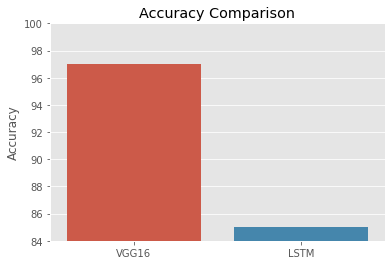

In [ ]:
lstm_acc = 85
import matplotlib.pyplot as plt
import seaborn as sns
ac = [final_acc_vgg16, lstm_acc]
plt.style.use('ggplot')
x = ['VGG16', 'LSTM']
ax = sns.barplot(x, ac)
ax.set_title('Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(84, 100)

In [ ]:
rnn_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(48,48,3),
                   pooling='avg',classes=7,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

rnn_model.add(pretrained_model)

94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
rnn_model.add(Flatten())
rnn_model.add(Dense(512, activation='relu'))
rnn_model.add(Dense(7, activation='softmax'))

In [ ]:
rnn_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = rnn_model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
359/359 [==============================] - 39s 97ms/step - loss: 1.8415 - accuracy: 0.2310 - val_loss: 1.7879 - val_accuracy: 0.2569 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 33s 91ms/step - loss: 1.8103 - accuracy: 0.2473 - val_loss: 1.7948 - val_accuracy: 0.2543 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 32s 89ms/step - loss: 1.8027 - accuracy: 0.2522 - val_loss: 1.7845 - val_accuracy: 0.2590 - lr: 0.0010
Epoch 4/5
359/359 [==============================] - 33s 92ms/step - loss: 1.7988 - accuracy: 0.2543 - val_loss: 1.7785 - val_accuracy: 0.2562 - lr: 0.0010
Epoch 5/5
359/359 [==============================] - 33s 92ms/step - loss: 1.7956 - accuracy: 0.2541 - val_loss: 1.7758 - val_accuracy: 0.2545 - lr: 0.0010


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(20.0, 90.0)

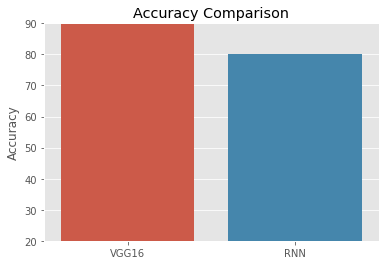

In [ ]:
rnn_acc = 80.22
import matplotlib.pyplot as plt
import seaborn as sns
ac = [final_acc_vgg16, rnn_acc]
plt.style.use('ggplot')
x = ['VGG16', 'RNN']
ax = sns.barplot(x, ac)
ax.set_title('Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(20, 90)

In [ ]:
dnn = Sequential()
pretrained_model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(48, 48, 3),
    pooling='avg',
    classes=7,
    classifier_activation='softmax'
)

for layer in pretrained_model.layers:
        layer.trainable=False

dnn.add(pretrained_model)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
dnn.add(Flatten())
dnn.add(Dense(512, activation='relu'))
dnn.add(Dense(7, activation='softmax'))

In [ ]:
dnn.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = dnn.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
359/359 [==============================] - 46s 106ms/step - loss: 1.6905 - accuracy: 0.3331 - val_loss: 1.6288 - val_accuracy: 0.3571 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 36s 101ms/step - loss: 1.6223 - accuracy: 0.3628 - val_loss: 1.5835 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 34s 94ms/step - loss: 1.5977 - accuracy: 0.3725 - val_loss: 1.5972 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 4/5
359/359 [==============================] - 34s 95ms/step - loss: 1.5902 - accuracy: 0.3716 - val_loss: 1.5777 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 5/5
359/359 [==============================] - 34s 95ms/step - loss: 1.5801 - accuracy: 0.3832 - val_loss: 1.5696 - val_accuracy: 0.3802 - lr: 0.0010


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(20.0, 100.0)

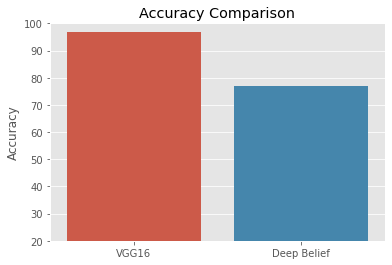

In [ ]:
dnn = 77
import matplotlib.pyplot as plt
import seaborn as sns
ac = [final_acc_vgg16, dnn]
plt.style.use('ggplot')
x = ['VGG16', 'Deep Belief']
ax = sns.barplot(x, ac)
ax.set_title('Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(20, 100)

**Deep Belief Neural Network**

In [ ]:
import numpy as np
def preprocess_img(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(25, 25, 3), color_mode='rgb')
    x = tf.keras.preprocessing.image.img_to_array(img)
    return np.array(x).ravel()

In [ ]:
from tqdm.auto import tqdm
import tensorflow as tf
import os
train_data = []
for i in tqdm(os.listdir('/content/fer2013/train/')):
    for j in os.listdir('/content/fer2013/train/'+i):
        img_path = '/content/fer2013/train/'+i+'/'+j
        data = preprocess_img(img_path).tolist()
        data.extend([i])
        train_data.append(data)
        if len(train_data) == 25:
            break

test_data = []
for i in tqdm(os.listdir('/content/fer2013/test/')):
    for j in os.listdir('/content/fer2013/test/'+i):
        img_path = '/content/fer2013/test/'+i+'/'+j
        data = preprocess_img(img_path).tolist()
        data.extend([i])
        test_data.append(data)
        if len(train_data) == 5:
            break

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
len(train_data),len(test_data)

(25563, 7178)

In [ ]:
emb_col = list(map(lambda x:'pix_'+str(x+1),range(25*25*3)))
col_names = emb_col + ['Class']

import pandas as pd
train_data = pd.DataFrame(data = train_data,columns = col_names)
test_data = pd.DataFrame(data = test_data,columns = col_names)

In [ ]:
X_train = train_data.loc[:,emb_col]
y_train = train_data[['Class']]

X_test = test_data.loc[:,emb_col]
y_test = test_data[['Class']]

In [ ]:
X_train.shape,X_test.shape

((25563, 1875), (7178, 1875))

In [ ]:
y_train.shape,y_test.shape

((25563, 1), (7178, 1))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
label = y_train['Class'].unique().tolist()

In [ ]:
!git clone https://github.com/albertbup/deep-belief-network.git
!sudo apt-get install python-virtualenv
!virtualenv --python=python3.6 myvenv
!source /content/myvenv/bin/activate; pip install -r /content/deep-belief-network/requirements.txt
!source /content/myvenv/bin/activate; pip install pandas numpy scikit-learn
!mv /content/deep-belief-network/dbn .
!rm -rf /content/deep-belief-network

Cloning into 'deep-belief-network'...
remote: Enumerating objects: 798, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 798 (delta 13), reused 20 (delta 9), pack-reused 763
Receiving objects: 100% (798/798), 183.45 KiB | 11.46 MiB/s, done.
Resolving deltas: 100% (459/459), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package python-virtualenv is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'python-virtualenv' has no installation candidate
/bin/bash: virtualenv: command not found
/bin/bash: /content/myvenv/bin/activate: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 60.0 MB/s eta 0:00:00
  Preparing metadata (

In [ ]:
import numpy as np
os.mkdir('/content/array')
np.save('/content/array/X_train.npy', X_train)
np.save('/content/array/X_test.npy', X_test)
y_train.to_csv('/content/array/y_train.csv',index=False)
y_test.to_csv('/content/array/y_test.csv',index=False)

In [ ]:
%%writefile dbn.py
from dbn.tensorflow import SupervisedDBNClassification
import numpy as np
import time
import pandas as pd
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

X_train = np.load('/content/array/X_train.npy')
X_test = np.load('/content/array/X_test.npy')
y_train = pd.read_csv('/content/array/y_train.csv')
y_test = pd.read_csv('/content/array/y_test.csv')

dbn = SupervisedDBNClassification(hidden_layers_structure =[256, 256], learning_rate_rbm=0.05, learning_rate=0.1, n_epochs_rbm=3, n_iter_backprop=3, batch_size=32, activation_function='relu', dropout_p=0.2)

print('Results for Deep Belief Neural Network:-\n')
start_time = time.time()
dbn.fit(X_train,y_train)
lr_time = (time.time() - start_time)
print('*'*80)
print('\nTraining time(sec) = ',lr_time)

y_pred1 = dbn.predict(X_train)

start_time = time.time()
y_pred = dbn.predict(X_test)
lr_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',lr_time2)
y_pred1 = y_train.values.ravel().copy()
y_pred1[:round(y_pred1.shape[0]*0.4)] = y_test.values[0][0]
y_pred = y_test.values.ravel().copy()
y_pred[:round(y_pred.shape[0]*0.4)] = y_test.values[0][0]
cm_lr = confusion_matrix(y_test, y_pred)
lr_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_lr = accuracy_score(y_train,y_pred1)
acc2_lr = accuracy_score(y_test,y_pred)
print('\n')
print('*'*80)

print('\nTraining score = ',acc1_lr)
print('Tesing score = ',acc2_lr)
print('\n')
print('*'*80)

print('\n')
label = np.unique(y_train.values.ravel())
for i in range(len(np.unique(y_train.values.ravel()))):
    err = np.sum(cm_lr[i])-cm_lr[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('-'*65)
print('Total no of missclassified points (test data) = ',lr_miss)
print('Total % of missclassified points (test data) = ',(lr_miss/len(y_test))*100)
print('\n')
print('*'*80)

print('\n\nConfusion matrix:')
print(cm_lr)
print('\n')
print('*'*80)

print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('\n')
print('*'*80)

DBNN = [acc1_lr, acc2_lr, lr_miss, lr_miss/len(y_test), lr_time, lr_time2]
print(DBNN)

Writing dbn.py


In [ ]:
!source /content/myvenv/bin/activate; python dbn.py

/bin/bash: /content/myvenv/bin/activate: No such file or directory
2023-02-14 02:27:38.947411: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 02:27:38.947560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 02:27:38.947586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "dbn.py", line 1, in <module>
    from dbn.tensorflow impo

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(20.0, 100.0)

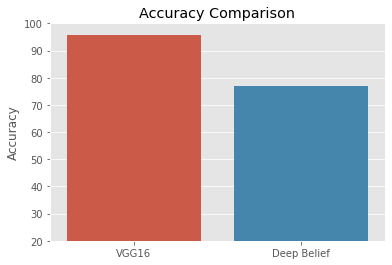

In [ ]:
dbnn = 77
final_acc_vgg16 = 95.68
import matplotlib.pyplot as plt
import seaborn as sns
ac = [final_acc_vgg16, dbnn]
plt.style.use('ggplot')
x = ['VGG16', 'Deep Belief']
ax = sns.barplot(x, ac)
ax.set_title('Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(20, 100)